#  Energy maps
- Computed via spectral integration
- Computed via mean squares

In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt

import drifters.utils as ut
import pynsitu as pin

from GDP_lib import root_dir

In [2]:
from dask.distributed import Client

if True:
    from dask_jobqueue import PBSCluster

    cluster = PBSCluster()
    w = cluster.scale(jobs=2)  # 2 not enough for lon, lat, year, binning
else:
    from dask.distributed import LocalCluster

    cluster = LocalCluster()

client = Client(cluster)
client

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.min

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.69:8787/status,
Dashboard: http://10.148.0.69:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.69:43374,Workers: 0
Dashboard: http://10.148.0.69:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
def geo_plot(d_array, title="", legend="", **kwargs):
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.EckertIII(central_longitude=-180))
    ax.add_feature(cfeature.LAND, zorder=2)
    d_array.rename(legend).plot(
        x="lon_bins", y="lat_bins", **kwargs, ax=ax, transform=ccrs.PlateCarree()
    )
    ax.set_extent([1e-4, -1e-4, -90, 90], ccrs.PlateCarree())
    ax.set_title(title, fontsize=15)
    gl = ax.gridlines(
        draw_labels=True,
    )

_______
# Energy map from spectra

In [4]:
zarr_argos = os.path.join(root_dir, "argos_geospectra_2_corrected.zarr")
zarr_gps = os.path.join(root_dir, "gps_geospectra_2.zarr")
zarr_gpsc = os.path.join(root_dir, "gps_geospectra_2_corrected.zarr")
dsg = xr.open_zarr(zarr_gps).persist()
dsgc = xr.open_zarr(zarr_gpsc).persist()
dsa = xr.open_zarr(zarr_argos).persist()

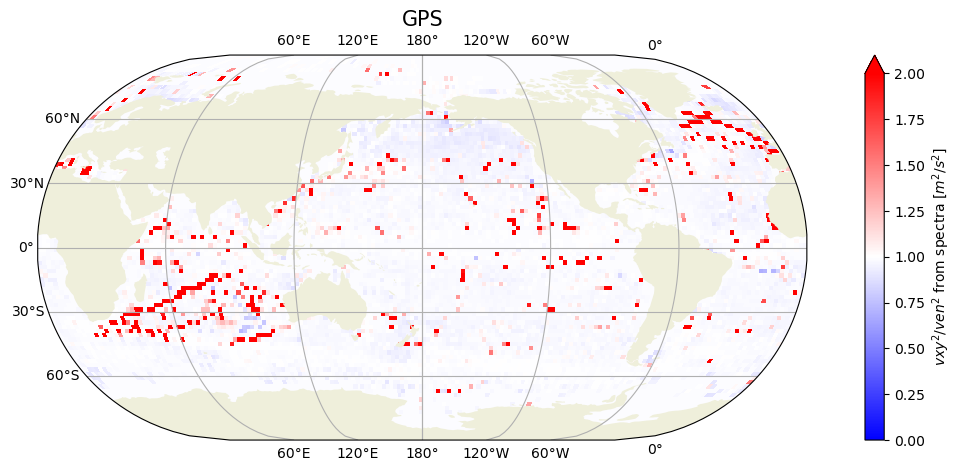

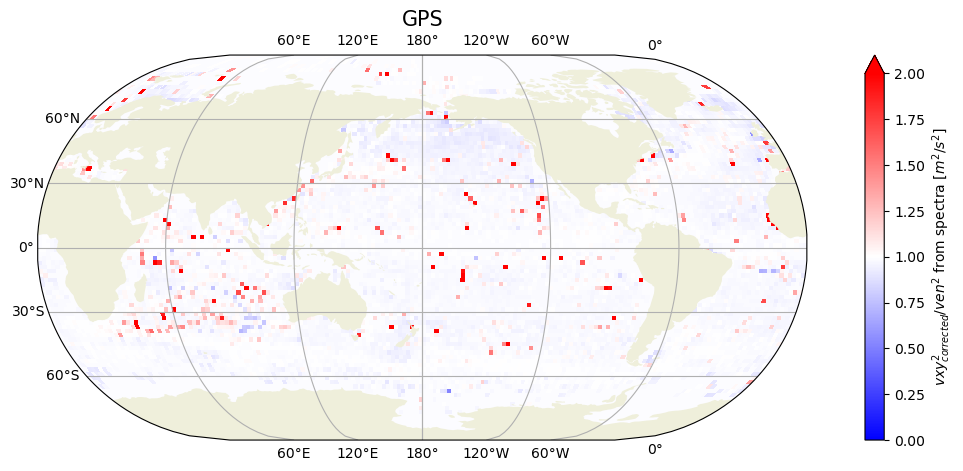

In [5]:
geo_plot(
    dsg.E_vxy.integrate("frequency") / dsg.E_ven.integrate("frequency"),
    legend=r"$vxy^2/ven^2$ from spectra [$m^2/s^2$]",
    title="GPS",
    vmax=2,
    vmin=0,
    cmap="bwr",
)

geo_plot(
    dsgc.E_vxy.integrate("frequency") / dsg.E_ven.integrate("frequency"),
    legend=r"$vxy^2_{corrected}/ven^2$ from spectra [$m^2/s^2$]",
    title="GPS",
    vmax=2,
    vmin=0,
    cmap="bwr",
)

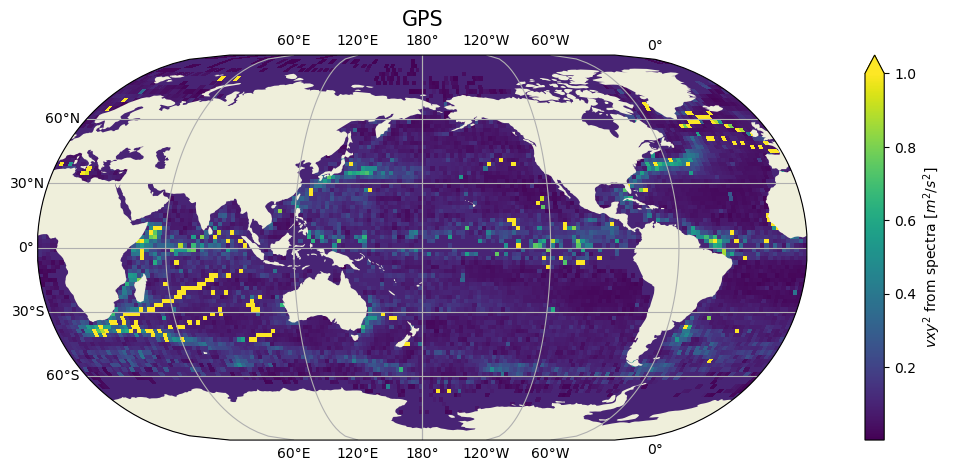

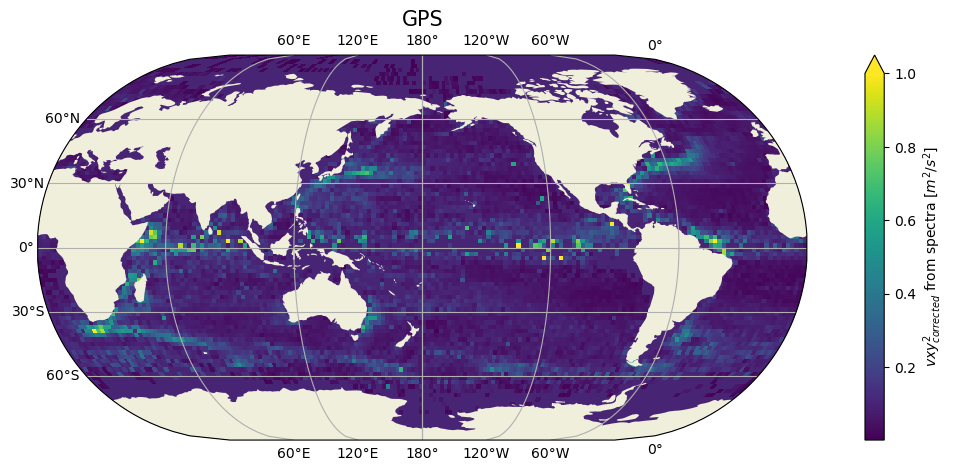

In [6]:
geo_plot(
    dsg.E_vxy.integrate("frequency"),
    legend=r"$vxy^2$ from spectra [$m^2/s^2$]",
    title="GPS",
    vmax=1,
)

geo_plot(
    dsgc.E_vxy.integrate("frequency"),
    legend=r"$vxy^2_{corrected}$ from spectra [$m^2/s^2$]",
    title="GPS",
    vmax=1,
)

___________
# Counts

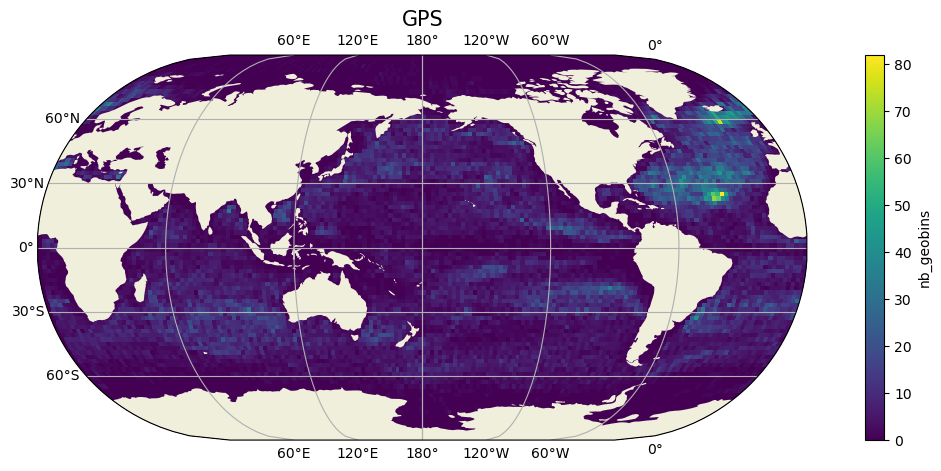

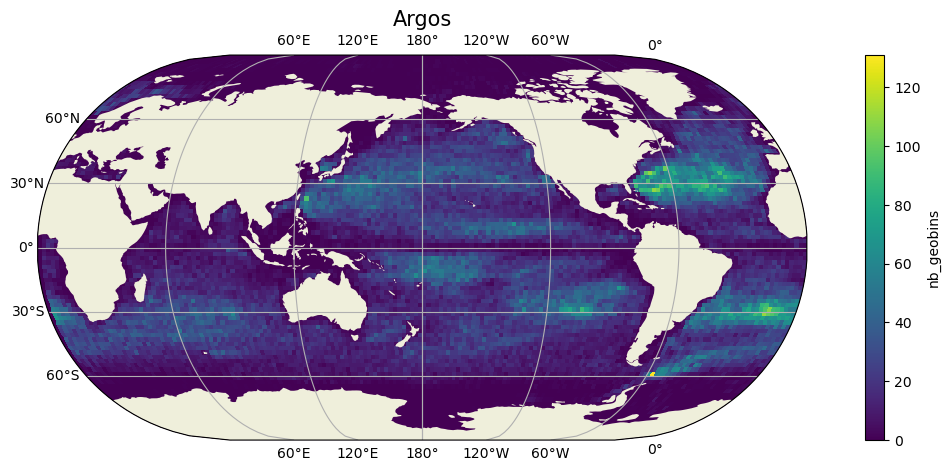

In [11]:
# nb counts
geo_plot(dsg.nb_geobins, legend="nb of points/bins", title="GPS")
geo_plot(dsa.nb_geobins, legend="nb of points/bins", title="Argos")

_______
# Computing root mean square

In [4]:
parquet_argos = os.path.join(root_dir, "argos_av_time.parquet")
parquet_gps = os.path.join(root_dir, "gps_av_time.parquet")
parquet_gpsc = os.path.join(root_dir, "gps_av_time_corrected.parquet")
dfg = dd.read_parquet(parquet_gps).persist()
dfgc = dd.read_parquet(parquet_gpsc).persist()
dfa = dd.read_parquet(parquet_argos).persist()

In [6]:
dfgc

,id,lon,lat,ve,vn,typebuoy,gap,deploy_date,deploy_lat,deploy_lon,end_date,end_lat,end_lon,drogue_lost_date,typedeath,lon360,err_lat,err_lon,err_ve,err_vn,x,y,vex,vny,vxy,ae,an,aen,aex,any,axy,ae_vex,an_vny,aen_vxy,dt,vex_diff,vny_diff,vxy_diff,lon_cut,lat_cut,ven,ven2,vxy2
npartitions=197,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,float32,float32,float32,float32,object,float64,datetime64[ns],float64,float64,datetime64[ns],float64,float64,datetime64[ns],float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,category[known],category[known],float32,float32,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
# bin geographically
def bins_geo(df, dl=2):
    lon_bins = np.arange(
        -180.0, 180.0 + dl, dl
    )  # CAUTION : add dl to upper bound (prevent from pb with last binning intervals)
    lat_bins = np.arange(-90, 90 + dl, dl)
    df["lon"] = (df["lon"] + 180) % 360 - 180
    df["lon_cut"] = df["lon"].map_partitions(pd.cut, bins=lon_bins).map(lambda x: x.mid)
    df["lat_cut"] = df["lat"].map_partitions(pd.cut, bins=lat_bins).map(lambda x: x.mid)


def norm_va(df):
    df["ven"] = np.sqrt(df["ve"] ** 2 + df["vn"] ** 2)
    df["ven2"] = df["ven"] ** 2
    df["vxy2"] = df["vxy"] ** 2


bins_geo(dfg)
bins_geo(dfgc)
bins_geo(dfa)
norm_va(dfgc)
norm_va(dfg)
norm_va(dfa)

l_var = ["ven2", "vxy2", "aen", "axy"]
dsvg = (
    dfg[["lon_cut", "lat_cut"] + l_var]
    .groupby(["lon_cut", "lat_cut"])
    .mean()
    .reset_index()
    .rename(columns={"lon_cut": "lon_bins", "lat_cut": "lat_bins"})
    .compute()
    .to_xarray()
    .set_index(index=["lon_bins", "lat_bins"])
    .unstack()
)
dsvgc = (
    dfgc[["lon_cut", "lat_cut"] + l_var]
    .groupby(["lon_cut", "lat_cut"])
    .mean()
    .reset_index()
    .rename(columns={"lon_cut": "lon_bins", "lat_cut": "lat_bins"})
    .compute()
    .to_xarray()
    .set_index(index=["lon_bins", "lat_bins"])
    .unstack()
)
dsva = (
    dfa[["lon_cut", "lat_cut"] + l_var]
    .groupby(["lon_cut", "lat_cut"])
    .mean()
    .reset_index()
    .rename(columns={"lon_cut": "lon_bins", "lat_cut": "lat_bins"})
    .compute()
    .to_xarray()
    .set_index(index=["lon_bins", "lat_bins"])
    .unstack()
)

In [ ]:
dsvgc

<xarray.Dataset>
Dimensions:   (lon_bins: 180, lat_bins: 90)
Coordinates:
  * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * lat_bins  (lat_bins) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Data variables:
    ven2      (lon_bins, lat_bins) float64 nan nan nan nan ... 0.003207 nan nan
    vxy2      (lon_bins, lat_bins) float64 nan nan nan nan ... 0.003205 nan nan
    aen       (lon_bins, lat_bins) float64 nan nan nan nan ... 1.306e-06 nan nan
    axy       (lon_bins, lat_bins) float64 nan nan nan nan ... 1.277e-06 nan nan

In [ ]:
geo_plot(
    dsvg["vxy2"] / dsvg["ven2"],
    legend=r"$  vxy^2/ven^2  $ [$m^2/s^2$]",
    title="GPS",
    vmax=2,
    cmap="bwr",
    vmin=0,
)
geo_plot(
    dsvgc["vxy2"] / dsvg["ven2"],
    legend=r"$vxy^2_{corrected}/ven^2 $ [$m^2/s^2$]",
    title="GPS",
    vmax=2,
    cmap="bwr",
    vmin=0,
)
geo_plot(
    dsvg["ven2"], legend=r"$\langle ven^2 \rangle$ [$m^2/s^2$]", title="GPS", vmax=1
)
geo_plot(
    dsvg["vxy2"], legend=r"$\langle vxy^2 \rangle$ [$m^2/s^2$]", title="GPS", vmax=1
)
geo_plot(
    dsvgc["vxy2"],
    legend=r"$\langle vxy^2_{corrected} \rangle$ [$m^2/s^2$]",
    title="GPS",
    vmax=1,
)

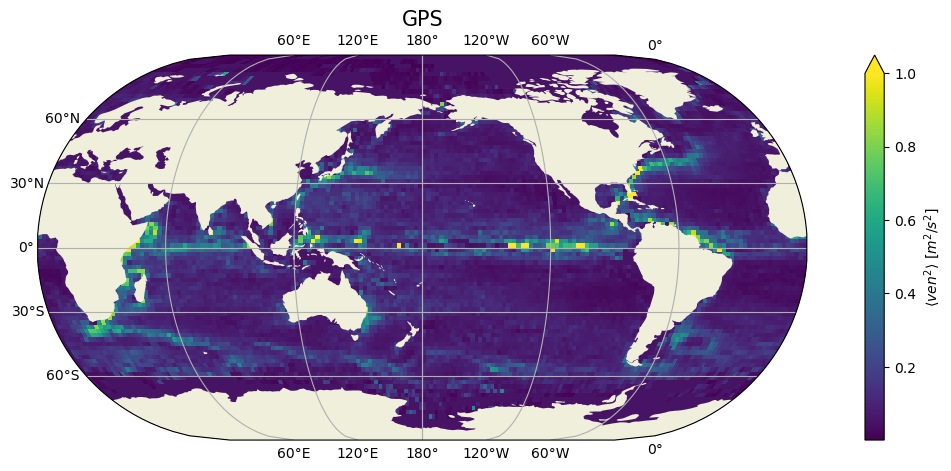

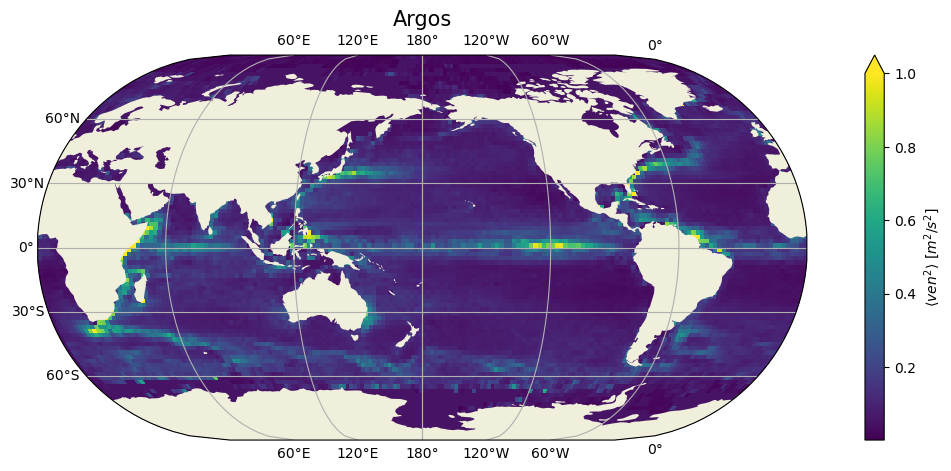

In [10]:
geo_plot(
    dsvg["ven2"], legend=r"$\langle ven^2 \rangle$ [$m^2/s^2$]", title="GPS", vmax=1
)
geo_plot(
    dsva["ven2"], legend=r"$\langle ven^2 \rangle$ [$m^2/s^2$]", title="Argos", vmax=1
)

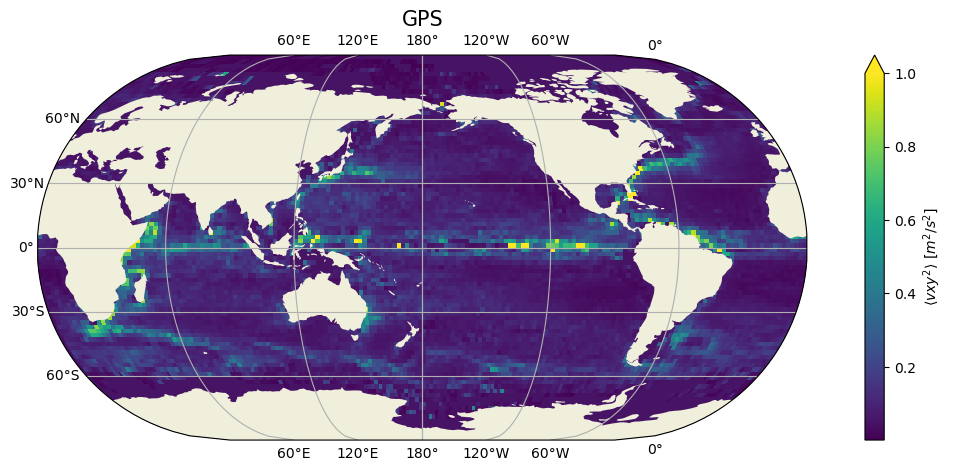

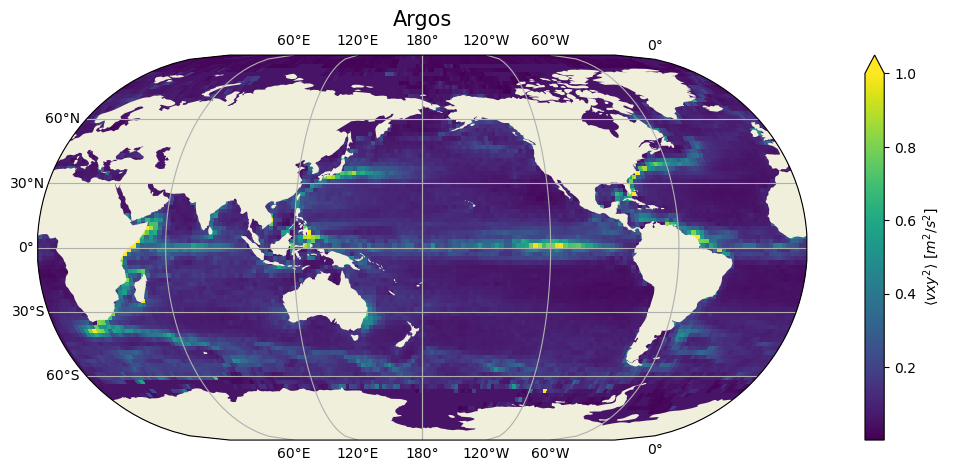

In [ ]:
geo_plot(
    dsvgc["vxy2"], legend=r"$\langle vxy^2 \rangle$ [$m^2/s^2$]", title="GPS", vmax=1
)
geo_plot(
    dsva["vxy2"], legend=r"$\langle vxy^2 \rangle$ [$m^2/s^2$]", title="Argos", vmax=1
)

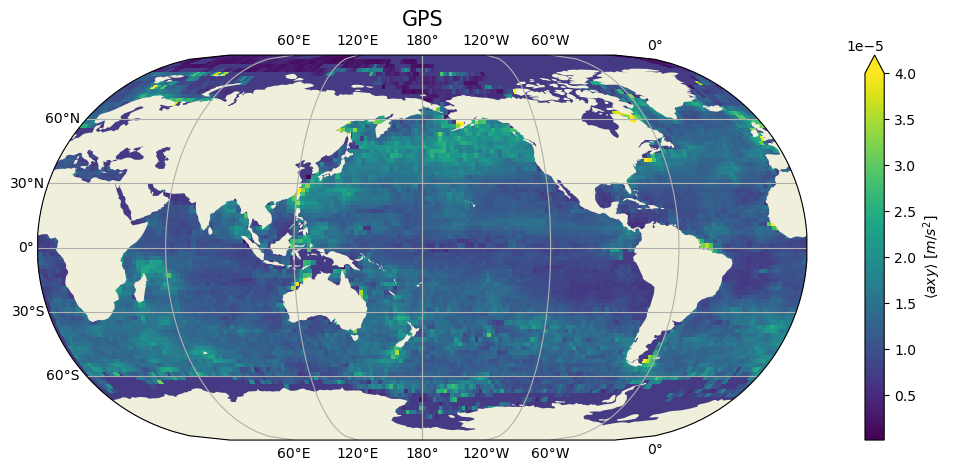

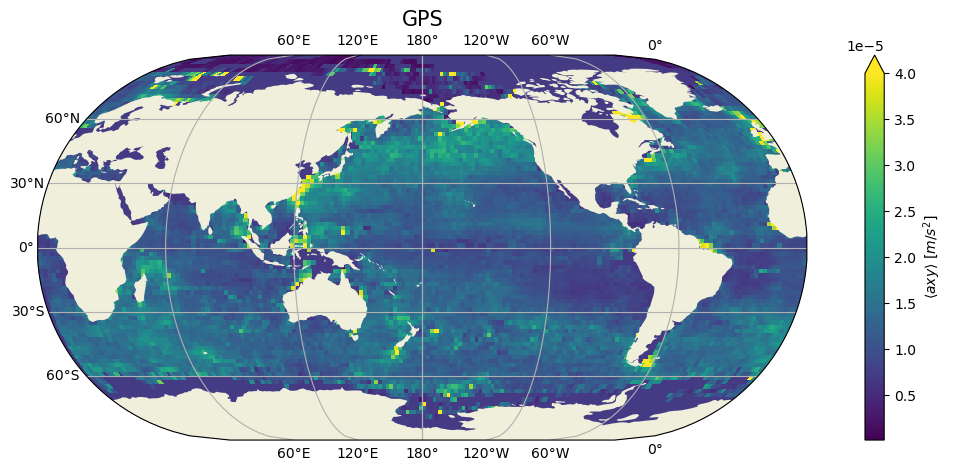

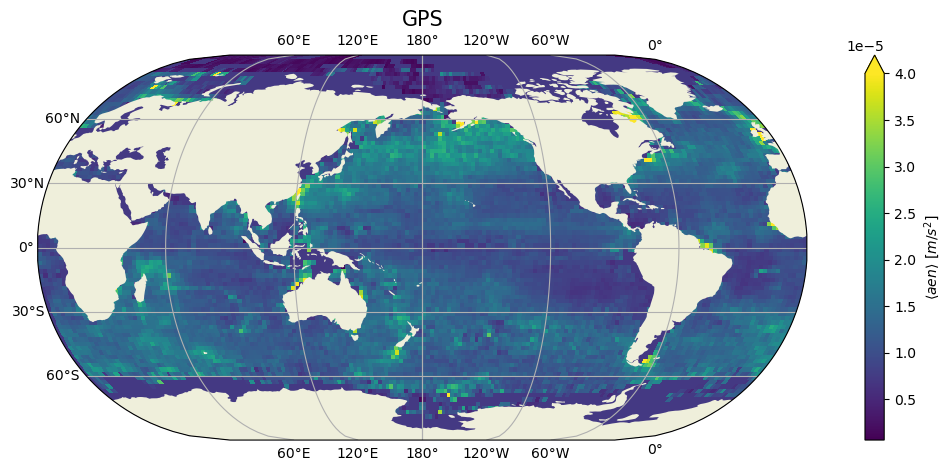

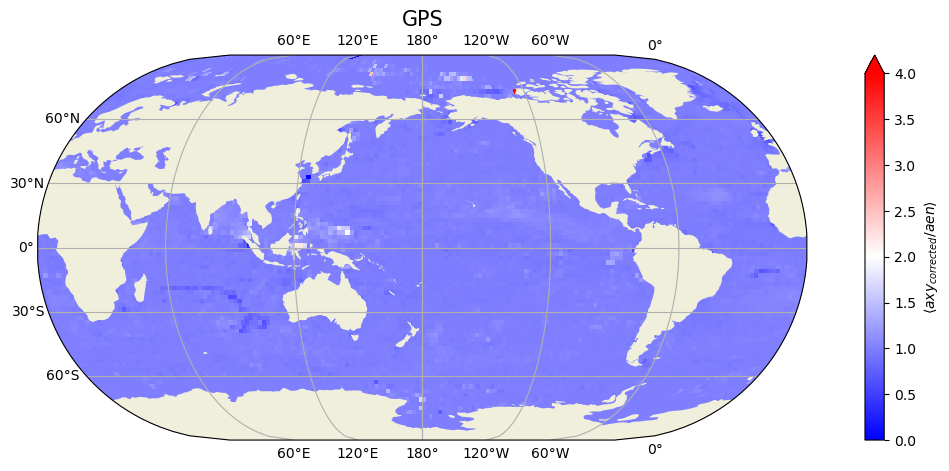

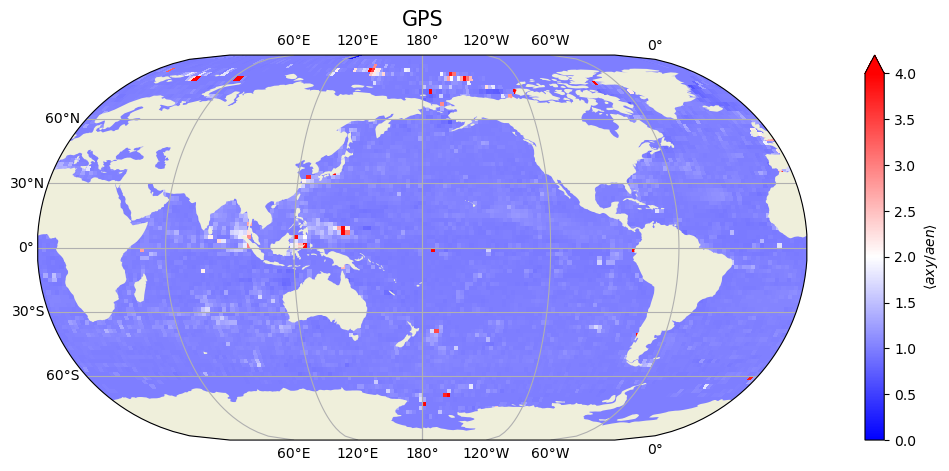

In [21]:
geo_plot(
    dsvgc["axy"], legend=r"$\langle axy \rangle$ [$m/s^2$]", title="GPS", vmax=4 * 1e-5
)
geo_plot(
    dsvg["axy"], legend=r"$\langle axy \rangle$ [$m/s^2$]", title="GPS", vmax=4 * 1e-5
)
geo_plot(
    dsvg["aen"], legend=r"$\langle aen \rangle$ [$m/s^2$]", title="GPS", vmax=4 * 1e-5
)
geo_plot(
    dsvgc["axy"] / dsvg["aen"],
    legend=r"$\langle axy_{corrected}/aen \rangle$",
    title="GPS",
    cmap="bwr",
    vmin=0,
    vmax=2,
)
geo_plot(
    dsvg["axy"] / dsvg["aen"],
    legend=r"$\langle axy/aen \rangle$",
    title="GPS",
    cmap="bwr",
    vmin=0,
    vmax=2,
)

___
### Map of nan value pourcentage


In [ ]:
dfg.vex.isnull().sum().compute()

1132475

In [ ]:
len(dfg.vex)

41635507

In [26]:
dfg[["lon_cut", "lat_cut", "vn", "ve", "vex", "vny"]].get_partition(0).compute()

,lon_cut,lat_cut,vn,ve,vex,vny
time,,,,,,
2001-07-01 02:00:00,-95.0,5.0,-0.2900,0.6460,0.640596,-0.277060
2001-07-01 03:00:00,-95.0,5.0,-0.2901,0.6466,0.649771,-0.294109
2001-07-01 04:00:00,-95.0,5.0,-0.2925,0.6440,0.656827,-0.308859
2001-07-01 05:00:00,-95.0,5.0,-0.2986,0.6368,0.660713,-0.317772
2001-07-01 06:00:00,-95.0,5.0,-0.3047,0.6296,0.660724,-0.317611
...,...,...,...,...,...,...
2008-07-11 11:00:00,-37.0,-31.0,-0.0469,0.0096,0.002234,-0.044347
2008-07-11 11:00:00,-47.0,-33.0,0.1115,-0.0126,-0.011078,0.106598
2008-07-11 11:00:00,-37.0,-31.0,-0.3986,-0.1271,-0.100299,-0.412189


In [45]:
def nan_ratio(df):
    df = df.copy()
    df["nan_vex"] = df.vex.isnull().sum() / len(df)
    df["nan_vny"] = df.vny.isnull().sum() / len(df)
    df["nan_vn"] = df.vn.isnull().sum() / len(df)
    df["nan_ve"] = df.ve.isnull().sum() / len(df)
    return df

In [47]:
df = (
    dfg[["lon_cut", "lat_cut", "vn", "ve", "vex", "vny", "id"]]
    .get_partition(0)
    .groupby("id")
    .get_group(22192)
    .compute()
)
meta = nan_ratio(df)
dfg_ = (
    dfg[["lon_cut", "lat_cut", "vn", "ve", "vex", "vny", "id"]]
    .groupby("id")
    .apply(nan_ratio, meta=meta)
)

In [49]:
l_var = [
    "nan_vex",
    "nan_vny",
    "nan_vn",
    "nan_ve",
]
dsg_ = (
    dfg_[["lon_cut", "lat_cut"] + l_var]
    .groupby(["lon_cut", "lat_cut"])
    .mean()
    .reset_index()
    .rename(columns={"lon_cut": "lon_bins", "lat_cut": "lat_bins"})
    .compute()
    .to_xarray()
    .set_index(index=["lon_bins", "lat_bins"])
    .unstack()
)

In [50]:
dsg_

<xarray.Dataset>
Dimensions:   (lon_bins: 180, lat_bins: 90)
Coordinates:
  * lon_bins  (lon_bins) float64 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * lat_bins  (lat_bins) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Data variables:
    nan_vex   (lon_bins, lat_bins) float64 nan nan nan nan ... 0.0 0.0 nan nan
    nan_vny   (lon_bins, lat_bins) float64 nan nan nan nan ... 0.0 0.0 nan nan
    nan_vn    (lon_bins, lat_bins) float64 nan nan nan nan ... 0.0 0.0 nan nan
    nan_ve    (lon_bins, lat_bins) float64 nan nan nan nan ... 0.0 0.0 nan nan

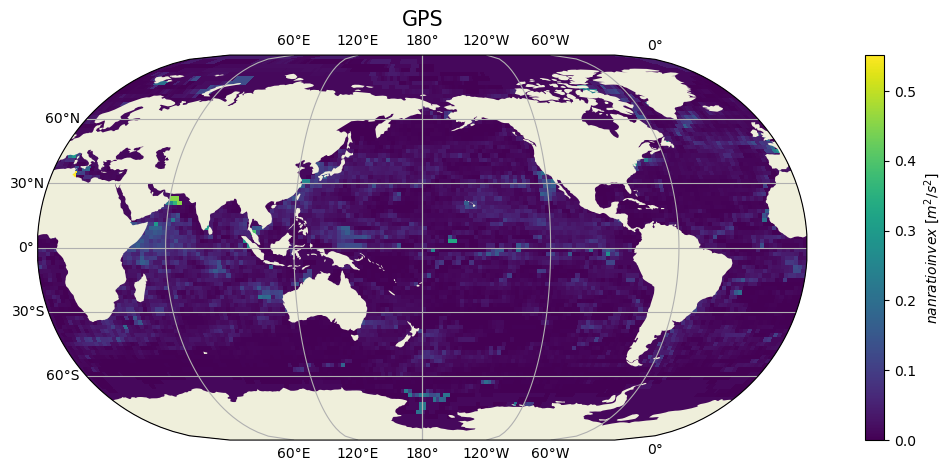

In [53]:
geo_plot(
    dsg_["nan_vny"],
    legend=r"$nan ratio in vex$ [$m^2/s^2$]",
    title="GPS",
)

In [36]:
dfg_[dfg_["nan_vex"] != 0].compute()

,lon_cut,lat_cut,vn,ve,vex,vny,nan_vex,nan_vny,nan_vn,nan_ve
time,,,,,,,,,,
2008-03-02 08:00:00,-45.0,-41.0,-0.5912,0.1644,0.168273,-0.571700,0.000863,0.000863,0.0,0.0
2008-03-02 09:00:00,-45.0,-41.0,-0.6214,0.1668,0.183236,-0.600647,0.000863,0.000863,0.0,0.0
2008-03-02 10:00:00,-45.0,-41.0,-0.6293,0.1881,0.198148,-0.629653,0.000863,0.000863,0.0,0.0
2008-03-02 11:00:00,-45.0,-41.0,-0.6372,0.2094,0.198089,-0.629714,0.000863,0.000863,0.0,0.0
2008-03-02 12:00:00,-45.0,-41.0,-0.6450,0.2306,0.242797,-0.634016,0.000863,0.000863,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-04-05 23:00:00,59.0,-33.0,-0.1338,-0.1644,-0.160881,-0.117524,0.000814,0.000814,0.0,0.0
2020-04-06 00:00:00,59.0,-33.0,-0.1471,-0.1517,-0.148695,-0.150370,0.000814,0.000814,0.0,0.0
2020-04-06 01:00:00,59.0,-33.0,-0.1732,-0.1275,-0.124037,-0.174519,0.000814,0.000814,0.0,0.0


In [22]:
cluster.close()

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.min